# Attention is all you need 

* https://arxiv.org/pdf/1706.03762.pdf
* https://github.com/eladhoffer/seq2seq.pytorch

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
import pickle
import random
import time
import math
import numpy as np
from konlpy.tag import Mecab;tagger=Mecab()
from collections import Counter
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from IPython.display import Image

torch.manual_seed(1)

In [2]:
USE_CUDA = torch.cuda.is_available()

# Transformer Architecture 

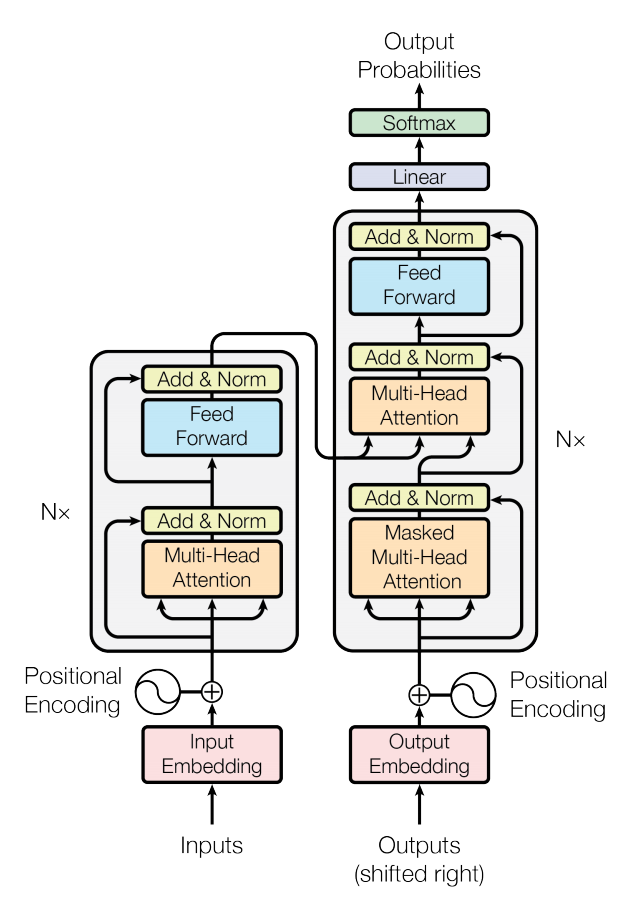

In [3]:
Image('../../images/attention_is_all_you_need_0.png')

# 1. Attention 

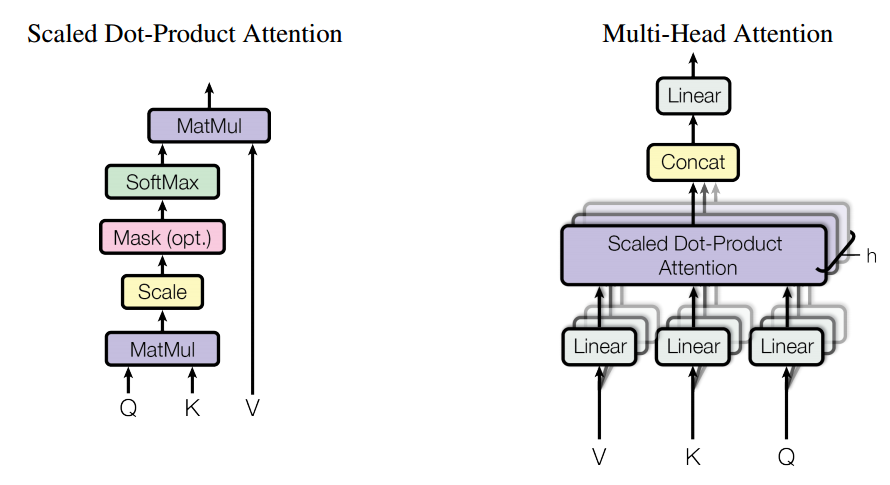

In [4]:
Image('../../images/attention_is_all_you_need_1.png')

## 1. Scaled Dot-Product Attention 

### * masking (eq, ByteTensor)

In [5]:
test = Variable(torch.LongTensor([0,1,2,3]))
test

Variable containing:
 0
 1
 2
 3
[torch.LongTensor of size 4]

In [6]:
mask = test.eq(0) # 그 심볼인 인덱스는 1로 True, 아니면 0 (ByteTensor)
mask

Variable containing:
 1
 0
 0
 0
[torch.ByteTensor of size 4]

In [7]:
test2 = Variable(torch.Tensor([2,3,2,3]))

In [8]:
test2.data.masked_fill_(mask.data,-float('inf'))


-inf
  3
  2
  3
[torch.FloatTensor of size 4]

In [9]:
class SDPAttention(nn.Module):
    """
    Scaled Dot-Product Attention
    """

    def __init__(self, dropout=0, causal=False):
        super(SDPAttention, self).__init__()
        self.causal = causal
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax()
        self.mask = None

    def set_mask(self, masked_tq):
        # masked_tq 는 ByteTensor
        # applies a mask of b x tq length
        self.mask = masked_tq

    def forward(self, q, k, v):
        b_q, t_q, dim_q = list(q.size())
        b_k, t_k, dim_k = list(k.size())
        b_v, t_v, dim_v = list(v.size())
        assert(b_q == b_k and b_k == b_v)  # batch size should be equal
        assert(dim_q == dim_k)  # dims should be equal
        assert(t_k == t_v)  # times should be equal
        b = b_q
        qk = torch.bmm(q, k.transpose(1, 2))  #1. MatMul(Q,K) :  b x t_q x t_k
        qk = qk / (dim_k ** 0.5) #2. Scale : dot-product의 결과가 너무 커져서 Counteract
        
        #3. Masking (Opt)
        if self.mask is not None:
            mask = self.mask.unsqueeze(1).expand(b, t_q, t_k)
            qk.data.masked_fill_(mask, -float('inf'))
            
        # ??? What    
        if self.causal:
            causal_mask = q.data.new(t_q, t_k).byte().fill_(1).triu_(1)
            causal_mask = causal_mask.unsqueeze(0).expand(b, t_q, t_k)
            qk.data.masked_fill_(causal_mask, -float('inf'))
            
        #4. SoftMax    
        sm_qk = self.softmax(qk.view(-1, t_k)).view(b, t_q, t_k)
        sm_qk = self.dropout(sm_qk)
        return torch.bmm(sm_qk, v)  #5. MatMul(,V) b x t_q x dim_v

## 2. Multi-Head Attention 

In [10]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention
    """
    def __init__(self, input_size, output_size, num_heads, dropout=0, causal=False):
        super(MultiHeadAttention, self).__init__()
        assert(input_size % num_heads == 0)
        self.input_size = input_size
        self.output_size = output_size
        self.num_heads = num_heads
        self.linear_q = nn.Linear(input_size, input_size)
        self.linear_k = nn.Linear(input_size, input_size)
        self.linear_v = nn.Linear(input_size, input_size)
        self.linear_out = nn.Linear(input_size, output_size)
        self.sdp_attention = SDPAttention(dropout=dropout, causal=causal)

    def set_mask(self, masked_tq):
        # applies a mask of b x tq length
        self.sdp_attention.mask = masked_tq

    def forward(self, q, k, v):

        b_q, t_q, dim_q = list(q.size())
        b_k, t_k, dim_k = list(k.size())
        b_v, t_v, dim_v = list(v.size())
        
        #1. Linear, Split
        qw = self.linear_q(q.view(-1, dim_q)).view(b_q, t_q, dim_q)
        kw = self.linear_k(k.view(-1, dim_k)).view(b_k, t_k, dim_k)
        vw = self.linear_v(v.view(-1, dim_v)).view(b_v, t_v, dim_v)
        
        #2. Parallel하게 Scaled Dot-Product attention
        qw = qw.chunk(self.num_heads, 2) # dimension 기준으로 num_heads 갯수대로 쪼갠다
        kw = kw.chunk(self.num_heads, 2) # 그래서 input_size % num_heads == 0
        vw = vw.chunk(self.num_heads, 2)
        output = []
        for i in range(self.num_heads):
            out_h = self.sdp_attention(qw[i], kw[i], vw[i])
            output.append(out_h)
        
        #3. 다시 Concat
        output = torch.cat(output, 2) 
        
        #4. 최종 Linear
        return self.linear_out(output.view(-1, output.size(2))).view(b_q, t_q, self.output_size)

# 2. Layer Normalization 

* https://arxiv.org/abs/1607.06450
* https://www.slideshare.net/ssuser06e0c5/normalization-72539464

In [11]:
help(test.expand_as)

Help on method expand_as in module torch.autograd.variable:

expand_as(tensor) method of torch.autograd.variable.Variable instance



In [12]:
class LayerNorm1d(nn.Module):

    def __init__(self, num_features, eps=1e-6, affine=True):
        super(LayerNorm1d, self).__init__()
        self.eps = eps
        self.num_features = num_features
        self.affine = affine
        if self.affine:
            self.weight = nn.Parameter(torch.Tensor(num_features))
            self.bias = nn.Parameter(torch.Tensor(num_features))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        if self.affine:
            self.weight.data.fill_(1.)
            self.bias.data.fill_(0.)

    def forward(self, inputs):
        b, t, _ = list(inputs.size())
        mean = inputs.mean(2).view(b, t, 1).expand_as(inputs)
        input_centered = inputs - mean
        std = input_centered.pow(2).mean(2).add(self.eps).sqrt()
        output = input_centered / std.view(b, t, 1).expand_as(inputs)

        if self.affine:
            w = self.weight.view(1, 1, -1).expand_as(output)
            b = self.bias.view(1, 1, -1).expand_as(output)
            output = output * w + b
        return output

## 3. Positional Embedding

In [13]:
import math

$$PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}}$$
$$PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}}$$

where $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2\pi$ to 10000$2\pi$. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

In [14]:
math.log(float(10000.) / float(1.) /(float(50.) - 1.)) # 1~10000 사이에 50차원 표현하기 위한 스케일

5.318520073865556

In [15]:
def positional_embedding(x, min_timescale=1.0, max_timescale=1.0e4):
    batch, length, channels = list(x.size()) 
    assert (channels % 2 == 0) # channel을 sin, cos 2개 사용하니까
    num_timescales = channels // 2
    log_timescale_increment = (
        math.log(float(max_timescale) / float(min_timescale)) /
        (float(num_timescales) - 1.))
    position = torch.range(0, length-1).float()
    inv_timescales = torch.range(0, num_timescales-1).float()
    if x.is_cuda:
        position = position.cuda()
        inv_timescales = inv_timescales.cuda()
    
    # exp는 각 element에 exponential 계산, _ 붙는건 리턴없이 in-place하게 처리하기
    inv_timescales.mul_(-log_timescale_increment).exp_().mul_(min_timescale)
    scaled_time = position.unsqueeze(1).expand(
        length, num_timescales) * inv_timescales.unsqueeze(0).expand(length, num_timescales)
    # scaled time is now length x num_timescales
    # length x channels
    signal = torch.cat([scaled_time.sin(), scaled_time.cos()], 1)
    return signal.unsqueeze(0).expand(batch, length, channels)

## 4. Encoder & Decoder

In [16]:
class EncoderBlock(nn.Module):

    def __init__(self, hidden_size=512, num_heads=8, inner_linear=1024, dropout=0):

        super(EncoderBlock, self).__init__()
        self.lnorm1 = LayerNorm1d(hidden_size)
        self.lnorm2 = LayerNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.attention = MultiHeadAttention(
            hidden_size, hidden_size, num_heads, dropout=dropout, causal=False)
        self.fc = nn.Sequential(nn.Linear(hidden_size, inner_linear),
                                nn.ReLU(inplace=True),
                                nn.Dropout(dropout),
                                nn.Linear(inner_linear, hidden_size))

    def set_mask(self, mask):
        self.attention.set_mask(mask)

    def forward(self, inputs):
        x = inputs
        res = x
        x = self.attention(x, x, x) # Self-Attention
        x = self.lnorm1(res + self.dropout(x))
        res = x
        x = x.view(-1, x.size(2))
        x = self.fc(x)
        x = x.view(res.size(0), res.size(1), res.size(2))
        x = self.lnorm2(res + self.dropout(x))

        return x

In [17]:
class DecoderBlock(nn.Module):

    def __init__(self, hidden_size=512, num_heads=8, inner_linear=1024, dropout=0):

        super(DecoderBlock, self).__init__()
        self.lnorm1 = LayerNorm1d(hidden_size)
        self.lnorm2 = LayerNorm1d(hidden_size)
        self.lnorm3 = LayerNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.attention = MultiHeadAttention(
            hidden_size, hidden_size, num_heads, dropout=dropout, causal=False)
        self.masked_attention = MultiHeadAttention(
            hidden_size, hidden_size, num_heads, dropout=dropout, causal=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, inner_linear),
                                nn.ReLU(inplace=True),
                                nn.Dropout(dropout),
                                nn.Linear(inner_linear, hidden_size))

    def set_mask(self, mask):
        self.attention.set_mask(mask)
        self.masked_attention.set_mask(mask)

    def forward(self, inputs, context):
        x = inputs
        res = x
        x = self.masked_attention(x, x, x) # subsequent positions에 attention하는 것을 방지
        x = self.lnorm1(res + self.dropout(x))
        res = x
        x = self.attention(x, context, context)
        x = self.lnorm2(res + self.dropout(x))
        res = x
        x = x.view(-1, x.size(2))
        x = self.fc(x)
        x = x.view(res.size(0), res.size(1), res.size(2))
        x = self.lnorm3(res + self.dropout(x))

        return x

In [18]:
class TransformerAttentionEncoder(nn.Module):

    def __init__(self, vocab_size, hidden_size=512, num_layers=6, num_heads=8, inner_linear=1024, mask_symbol=0, dropout=0):

        super(TransformerAttentionEncoder, self).__init__()
        self.mask_symbol = mask_symbol
        self.embedder = nn.Embedding(vocab_size, hidden_size, padding_idx=PAD)
        self.scale_embedding = hidden_size ** 0.5
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([EncoderBlock(hidden_size, num_heads, inner_linear, dropout)
                                     for _ in range(num_layers)
                                     ])

    def forward(self, inputs, hidden=None):
        if self.mask_symbol:
            padding_mask = inputs.eq(self.mask_symbol)
        else:
            padding_mask = None
        x = self.embedder(inputs) * self.scale_embedding
        x = x + Variable(positional_embedding(x), requires_grad=False)
        x = self.dropout(x)

        for block in self.blocks:
            block.set_mask(padding_mask)
            x = block(x)

        return x

In [19]:
class TransformerAttentionDecoder(nn.Module):

    def __init__(self, vocab_size, hidden_size=512, num_layers=6, num_heads=8, dropout=0, inner_linear=1024, tie_embedding=True):

        super(TransformerAttentionDecoder, self).__init__()
        self.embedder = nn.Embedding(vocab_size, hidden_size, padding_idx=PAD)
        self.scale_embedding = hidden_size ** 0.5
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([DecoderBlock(hidden_size, num_heads, inner_linear, dropout)
                                     for _ in range(num_layers)
                                     ])
        self.classifier = nn.Linear(hidden_size, vocab_size)    
    
        # We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.
        if tie_embedding:
            self.embedder.weight = self.classifier.weight

    def forward(self, inputs, context):
        x = self.embedder(inputs) * self.scale_embedding
        x = x + Variable(positional_embedding(x), requires_grad=False)
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x, context)
        x = x.view(-1, x.size(2))
        x = self.classifier(x)

        x = x.view(inputs.size(0), inputs.size(1), -1)
        return x, context

# 데이터 

In [20]:
def prepare_sequence(seq, to_ix):
    idxs = list(map(lambda w: to_ix[w], seq))
    tensor = torch.LongTensor(idxs)
    return Variable(tensor)

In [21]:
UNK_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'
BOS_TOKEN = '<s>'
EOS_TOKEN = '<\s>'

PAD, UNK, BOS, EOS = [0, 1, 2, 3]
SEQ_LENGTH=10
LANGUAGE_TOKENS = lambda lang: '<%s>' % lang

In [22]:
data = open('../../dataset/corpus/dsksd_chat.txt').readlines()
data = [[t.split('\\t')[0],t.split('\\t')[1][:-1]] for t in data if t !='\n']
DATA_SIZE = len(data) # 배치 사이즈
train=[]
for t0,t1 in data:
    token0 = tagger.morphs(t0)
    
    if len(token0)>=SEQ_LENGTH:
        token0= token0[:SEQ_LENGTH-1]
    token0.append("</s>")

    token1 = tagger.morphs(t1)
    if len(token1)>=SEQ_LENGTH:
        token1=token1[:SEQ_LENGTH-1]
    
    token1.append("</s>")
    while len(token0)<SEQ_LENGTH:
        token0.append('<pad>')
    
    while len(token1)<SEQ_LENGTH:
        token1.append('<pad>')
    
    train.append([token0,token1])

In [23]:
n_words=3
word2index={"<pad>":0,"<s>":1,"</s>":2}

for t0,t1 in train:
    for token in t0+t1:
        if token not in word2index:
            word2index[token]=n_words
            n_words+=1

index2word = {v:k for k,v in word2index.items()}

In [24]:
train_x=[]
train_y=[]
lengths=[]
for tr in train:
    temp = prepare_sequence(tr[0], word2index)
    temp = temp.view(1,-1)
    train_x.append(temp)

    temp2 = prepare_sequence(tr[1],word2index)
    temp2 = temp2.view(1,-1)
    train_y.append(temp2)
    
    length = [t for t in tr[1] if t !='PAD']
    lengths.append(len(length))

inputs = torch.cat(train_x)
targets = torch.cat(train_y)

del train_x
del train_y

# 트레이닝 

In [25]:
len(word2index)

462

In [34]:
vocab_size= len(word2index)
hidden_size= 30#512
num_layers= 2 #6
num_heads= 3 #8
inner_linear= 256#2048
dropout=0.1
tie_embedding=True
STEP=100

In [35]:
encoder = TransformerAttentionEncoder(vocab_size, hidden_size=hidden_size,
                                                   num_layers=num_layers, num_heads=num_heads, inner_linear=inner_linear,
                                                   dropout=dropout)

decoder = TransformerAttentionDecoder(vocab_size, hidden_size=hidden_size,
                                                   num_layers=num_layers, num_heads=num_heads, inner_linear=inner_linear,
                                                   dropout=dropout, tie_embedding=tie_embedding)


# we use learned embeddings to convert the input tokens and output tokens to vectors of dimension d_model
if tie_embedding:
    encoder.embedder.weight = decoder.classifier.weight

In [36]:
loss_function = nn.CrossEntropyLoss()
optim_encoder = optim.Adam(params=encoder.parameters(),lr=0.1)
optim_decoder = optim.Adam(params=decoder.parameters(),lr=0.1)

In [37]:
decoder_input = Variable(torch.LongTensor([[BOS]*DATA_SIZE])).transpose(1,0)
losses=[]

In [38]:
for step in range(STEP):
    
    encoder.zero_grad()
    decoder.zero_grad()
    
    context = encoder(inputs)
    
    decoded=[]
    for index in range(SEQ_LENGTH):
        x_, context = decoder(decoder_input,context)
        v,decoder_input = torch.max(x_.squeeze(1),1)
        decoded.append(x_)
        
    score = torch.cat(decoded,1)
    
    loss = loss_function(score.view(score.size(0)*score.size(1),-1),targets.view(-1))
    losses.append(loss)
    loss.backward(retain_variables=True)
    optim_encoder.step()
    optim_decoder.step()
    
    if step % 10==0:
        print(step, loss.data.tolist()[0])

0 6.215961933135986
10 3.422210454940796
20 3.2384841442108154
30 3.200744390487671
40 3.1817691326141357
50 3.169999122619629
60 3.1671903133392334
70 3.1636641025543213
80 3.1650516986846924
90 3.160187005996704
